# Lab: CNN Tuning and Visualization

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install and Update Packages

In [4]:
!pip install wandb --upgrade
!pip install grad-cam
!pip install matplotlib --upgrade

## Mount Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/Lab Data/'

Mounted at /content/gdrive


## Import Modules

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from multiprocessing import cpu_count
from sklearn.metrics import classification_report, cohen_kappa_score
from collections import Counter, OrderedDict, defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import os
import copy
import csv
import wandb
from pytorch_grad_cam import GradCAM

## Basic Configurations

In [7]:
wandb_args = dict(
    api_key = 'cf1e3716766ea55c8a8a19ff46c5d7bb11eec270', # Your API Key (access from settings)
    entity = 'u1992450',  # Your W&B username
    project = 'lab_x'
)

#################################################
# Tune the hyperparameters here
# You need not tweak/set all the hyperparameters
# Feel free to leave some out if you wish
# config = dict(
#     lr = 1e-4, wt = 1e-6,
#     step = 5, gamma = 0.1,
#     epochs = 10,
# )
############Syma Afsha  tweak hyperparameters. Extra Credits
config = dict(
    lr = 1e-4, wt = 1e-6,
    step = 25, gamma = 0.1,
    epochs = 25,
)
#################################################

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threads = cpu_count()

wandb: Currently logged in as: u1992450. Use `wandb login --relogin` to force relogin


## Preprocess Data

### Fetch the Dataset

I increase step size size which was 5 and now it is 25. It means the learning rate will be updated in every 25 epochs. I have also increased the value of epoch so that the model can learn more from the data. If there is no significant improvement in the loss after few epochs, we have stopped training the model at that moment, which is called early stopping to reduce overfitting.

In [8]:
!unzip -q "$root_dir""lidar_dataset.zip"
data_dir = '/content/dataset/'

mode = 'train'

###Compute Mean and Standard Deviation for Normalization

In [9]:
def computeDatasetStats(loader):
    mean, std  = 0, 0
    samples = 0.
    for images, _ in loader:
        mean += torch.mean(images, dim=(0,2,3))
        std += torch.std(images, dim=(0,2,3))
        samples += 1
    mean /= samples
    std /= samples
    return mean, std

data_transforms = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), data_transforms)
train_dataloader = DataLoader(train_data, batch_size=1024, num_workers=1)

mean, std = computeDatasetStats(train_dataloader)

###Define and Apply Transformations

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
            for x in ['train','test']}

data_sizes = {x: len(data[x]) for x in ['train','test']}

class_names = data['train'].classes
num_classes = len(class_names)

###Split Data into Training and Validation Sets

In [11]:
train_data_len = int(0.8*data_sizes['train'])
val_data_len = data_sizes['train']-train_data_len
data['train'], data['val'] = random_split(data['train'], (train_data_len,val_data_len))
data_sizes['train'] = train_data_len
data_sizes['val'] = val_data_len

### Sample and Load the Datasets

In [12]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    Adapted From:
        https://github.com/ufoym/imbalanced-dataset-sampler
    """

    def __init__(self, dataset, indices=None, num_samples=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is datasets.ImageFolder:
            return dataset.imgs[idx][1]
        elif dataset_type is Subset:
            return dataset[idx][1]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                    self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


samples = {x: max(Counter((lbl for _,lbl in data[x])).values())*num_classes
                for x in ['train','val']}
samples['test'] = max(Counter((data['test'].targets)).values())*num_classes
samplers = {x: ImbalancedDatasetSampler(data[x], num_samples=samples[x])
                for x in ['train','val','test']}
dataloaders = {x: DataLoader(data[x], batch_size=128, num_workers=1, sampler=samplers[x])
                for x in ['train','val','test']}

## Or Fetch and Preprocess Test Data (to Evaluate Pretrained Models)

In [ ]:
!unzip -q "$root_dir""lidar_test_dataset.zip"
test_data_dir = '/content/test_dataset/'

data_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
test_data = datasets.ImageFolder(test_data_dir, data_transforms)
class_names = test_data.classes

test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
mode = 'test'

# Define the Network Architecture
### **Note:** Re-run this code cell each time you want to train the network from scratch!!

In [ ]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
                            ('conv0', nn.Conv2d(1,6,kernel_size=(9, 9), groups = 1)),
                            ('relu0', nn.ReLU()),
                            ('batch0', nn.BatchNorm2d(6)),
                            ('pool0', nn.MaxPool2d(kernel_size=(2, 2))),

                            ('conv1', nn.Conv2d(6,12,kernel_size=(9, 9), groups = 6)),
                            ('relu1', nn.ReLU()),
                            ('batch1', nn.BatchNorm2d(12)),
                            ('pool1', nn.MaxPool2d(kernel_size=(2, 2))),
                        ]))
        self.classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(4332,100)),
                            ('relu2', nn.ReLU()),
                            ('batch2', nn.BatchNorm1d(100)),

                            ('fc2', nn.Linear(100,3)),
                            ('softmax', nn.Softmax()),
                            ('batch3', nn.BatchNorm1d(3)),
                            ('fc3', nn.Linear(3,3)),
                        ]))

    def forward(self, x):
        out = self.features(x)          # extract features
        out = out.view(out.size(0),-1)  # flatten
        out = self.classifier(out)      # classify
        return out


net = LiNet()

In [13]:
import torch
import torch.nn as nn

class SeparableConv2D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True) -> None:
        super().__init__()

        # Depthwise convolution
        self.depthwise_conv = nn.Conv2d(in_channels=in_channels,
                                        out_channels=in_channels,
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=padding,
                                        groups=in_channels,
                                        bias=bias)

        # Pointwise convolution
        self.pointwise_conv = nn.Conv2d(in_channels=in_channels,
                                        out_channels=out_channels,
                                        kernel_size=(1, 1),
                                        stride=1,
                                        padding=0,
                                        groups=1,
                                        bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x


In [14]:
import torch.nn as nn
from collections import OrderedDict

class SeparableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True) -> None:
        super().__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=bias)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, (1, 1), stride=1, padding=0, groups=1, bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x

class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('Sep_conv1', SeparableConv2D(in_channels=1, out_channels=6, kernel_size=(9, 9), bias=True)),
            ('relu1', nn.ReLU()),
            ('batch1', nn.BatchNorm2d(6)),
            ('pool1', nn.MaxPool2d(kernel_size=(2, 2))),

            ('Sep_conv2', SeparableConv2D(in_channels=6, out_channels=12, kernel_size=(9, 9), bias=True)),
            ('relu2', nn.ReLU()),
            ('batch2', nn.BatchNorm2d(12)),
            ('pool2', nn.MaxPool2d(kernel_size=(2, 2))),
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(4332, 100)),
            ('relu3', nn.ReLU()),
            ('batch3', nn.BatchNorm1d(100)),
            ('fc2', nn.Linear(100, 3)),
            ('softmax', nn.Softmax(dim=1)),  # Added dim=1 for softmax
            ('batch4', nn.BatchNorm1d(3)),
            ('fc3', nn.Linear(3, 3)),
        ]))

    def forward(self, x):
        out = self.features(x)          # extract features
        out = out.view(out.size(0), -1) # flatten
        out = self.classifier(out)      # classify
        return out

net = LiNet()


## Check if everything works correctly

In [15]:

# Create a dummy tensor of size (B x C x H x W) and pass it through the network
dummy_input = torch.randn(11, 1, 100,100)

# Pass the dummy input through the network
output = net(dummy_input)

# Print the shape of the output
print("Output shape:", output.shape)

Output shape: torch.Size([11, 3])


##And (optionally) load a pretrained model

In [ ]:
state_dict = torch.load(root_dir+'LiNet-adam_lr1e4_decay1e6.pth')
net.load_state_dict(state_dict)
net.eval()

FileNotFoundError: ignored

# Determine the number of Parameters

In [16]:
param_count = sum(p.numel() for p in net.parameters()) / 1000000
print('\nTotal Parameter Count: %.2f M' % param_count)


Total Parameter Count: 0.43 M


### Can you determine the number of parametres in the feature extractor?

#Train and Validate

### **Note**: Re-run the code cell that defines the network architecture before starting a new run!!

Saving checkpoints in: /content/gdrive/My Drive/Lab Data/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/Lab Data/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/25
----------
Train Loss: 0.5456 Acc: 0.9016
Val Loss: 0.4825 Acc: 0.9137

Epoch 2/25
----------
Train Loss: 0.3363 Acc: 0.9749
Val Loss: 0.3896 Acc: 0.9090

Epoch 3/25
----------
Train Loss: 0.2196 Acc: 0.9882
Val Loss: 0.3417 Acc: 0.9095

Epoch 4/25
----------
Train Loss: 0.1435 Acc: 0.9938
Val Loss: 0.2985 Acc: 0.9148

Epoch 5/25
----------
Train Loss: 0.0949 Acc: 0.9963
Val Loss: 0.2872 Acc: 0.9096

Epoch 6/25
----------
Train Loss: 0.0645 Acc: 0.9973
Val Loss: 0.2877 Acc: 0.9050

Epoch 7/25
----------
Train Loss: 0.0424 Acc: 0.9982
Val Loss: 0.3101 Acc: 0.8975

Epoch 8/25
----------
Train Loss: 0.0317 Acc: 0.9978
Val Loss: 0.2824 Acc: 0.9096

Epoch 9/25
----------
Train Loss: 0.0223 Acc: 0.9982
Val Loss: 0.3210 Acc: 0.9029

Epoch 10/25
----------
Train Loss: 0.0162 Acc: 0.9987
Val Loss: 0.3462 Acc: 0.8998

Epoch 11/25
-----

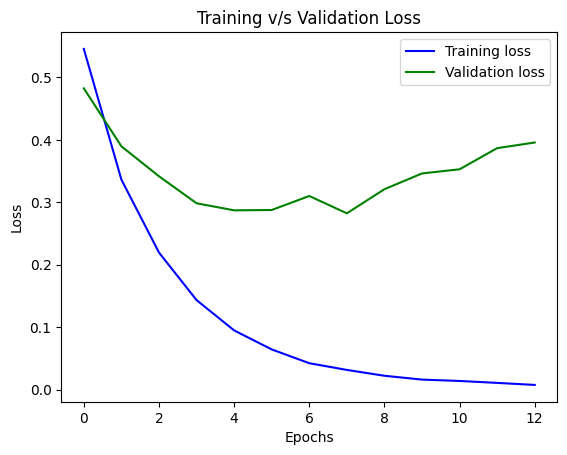

In [17]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=config['epochs'],
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

# Evaluate the Model

In [18]:
def evaluate_model(model, classes, dataloader, out_file_path='accuracy.txt'):
    model.cpu()
    num_classes = len(classes)
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    y_true = torch.ByteTensor()
    y_pred = torch.ByteTensor()

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            num_labels = labels.size(0)
            total += num_labels
            correct += c.sum().item()
            for i in range(num_labels):         # current batch size
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            y_true = torch.cat((y_true,labels), 0)
            y_pred = torch.cat((y_pred,predicted), 0)

    with open(out_file_path, "w") as out_file:
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total))
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total), file=out_file)
        for i in range(num_classes):
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]))
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]),
                  file=out_file)
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)))
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)),
              file=out_file)
        print('\n',classification_report(y_true, y_pred, target_names=class_names))
        print('\n',classification_report(y_true, y_pred, target_names=class_names),
              file=out_file)


!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-xxx-accuracy.txt"
evaluate_model(net, class_names, dataloaders['test'] if mode=='train' else test_dataloader, out_file_path)

Accuracy of the network on 4851 test images: 97.4232%
	Accuracy of corridor : 98.0024%
	Accuracy of door : 95.4887%
	Accuracy of room : 98.7523%

Kappa Score: 0.9613

               precision    recall  f1-score   support

    corridor       0.97      0.98      0.98      1652
        door       0.98      0.95      0.97      1596
        room       0.97      0.99      0.98      1603

    accuracy                           0.97      4851
   macro avg       0.97      0.97      0.97      4851
weighted avg       0.97      0.97      0.97      4851



# Estimate the Inference Speed

In [19]:
def get_fps(model, dataloader, reps=10):
    model.to(device)
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]

            # GPU warmup
            if device == 'cuda':
                for _ in range(10):
                    _ = model(inputs)
                torch.cuda.synchronize()

            start = time.time()
            for i in range(reps):
                _ = model(inputs)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            elapsed_time = (end-start)
            inference_speed = elapsed_time / (reps * batch_size)
            throughput = (reps * batch_size) / elapsed_time
            break
    print('Inference speed: %.4f s' % inference_speed)
    print('Throughput: %d images' % throughput)

get_fps(net, dataloaders['test'] if mode=='train' else test_dataloader)

Inference speed: 0.0000 s
Throughput: 84521 images


# Make Predictions

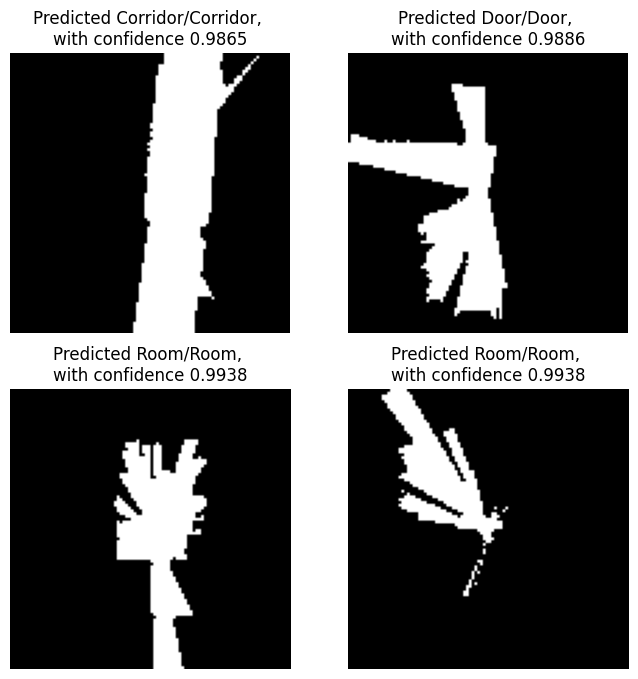

In [20]:

def predict(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(8,8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)                      # batch x channel x width x height
            labels = labels.to(device)

            outputs = model(inputs)                         # batch x classes
            prob = nn.functional.softmax(outputs, dim=-1)
            prob, idx = prob.sort(1,True)                   # batch x classes

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if num_images == 1:
                    ax = plt.subplot(1, 1, 1)
                else:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted {1}/{2}, \nwith confidence {0:.4f}'.format(prob[j][0],
                    class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
                ax.imshow(inputs.cpu().data[j].squeeze(), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


predict(net, dataloaders['test'] if mode=='train' else test_dataloader)

In [ ]:
# import torch

# def analyze_errors(model, dataloader, class_names):
#     model.eval()  # Set the model to evaluation mode
#     misclassified_examples = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             outputs = model(inputs)
#             _, predictions = torch.max(outputs, 1)

#             for i in range(inputs.size(0)):
#                 if predictions[i] != labels[i]:
#                     misclassified_examples.append((inputs[i], predictions[i], labels[i]))

#     # Analyzing a few misclassified examples
#     for i, (input, pred, label) in enumerate(misclassified_examples[:5]):  # Adjust the number as needed
#         print(f"Example {i}: True label: {class_names[label]}, Predicted: {class_names[pred]}")
#         # Add visualization or further analysis as needed

# # Assuming 'dataloaders' contains your test DataLoader and 'class_names' is a list of class names
# analyze_errors(model, dataloaders['test'], class_names)


# Visualize Filters (Features) and Activations (Feature Maps)

In [ ]:
def get_convs(layers):
    conv_layers = []
    for module in layers:
        if 'Conv2d' in str(type(module)):
            conv_layers.append(module)
        elif type(module)==nn.Sequential:
            conv_layers.extend(get_convs(module.children()))
    return conv_layers

convs = get_convs(net.features)
for conv in convs:
    print(f'CONV: {conv} => SHAPE: {conv.weight.shape}')

CONV: Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([6, 1, 9, 9])
CONV: Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1), groups=6) => SHAPE: torch.Size([12, 1, 9, 9])


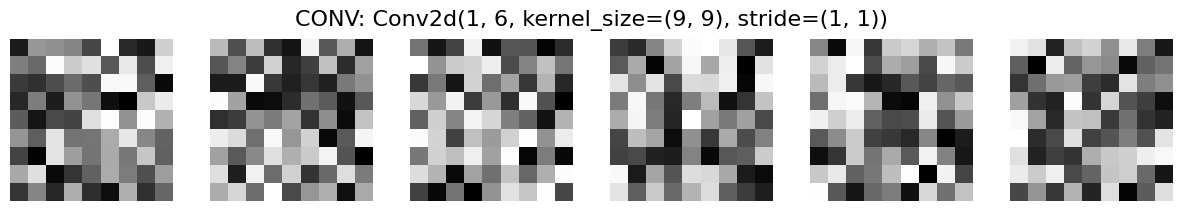

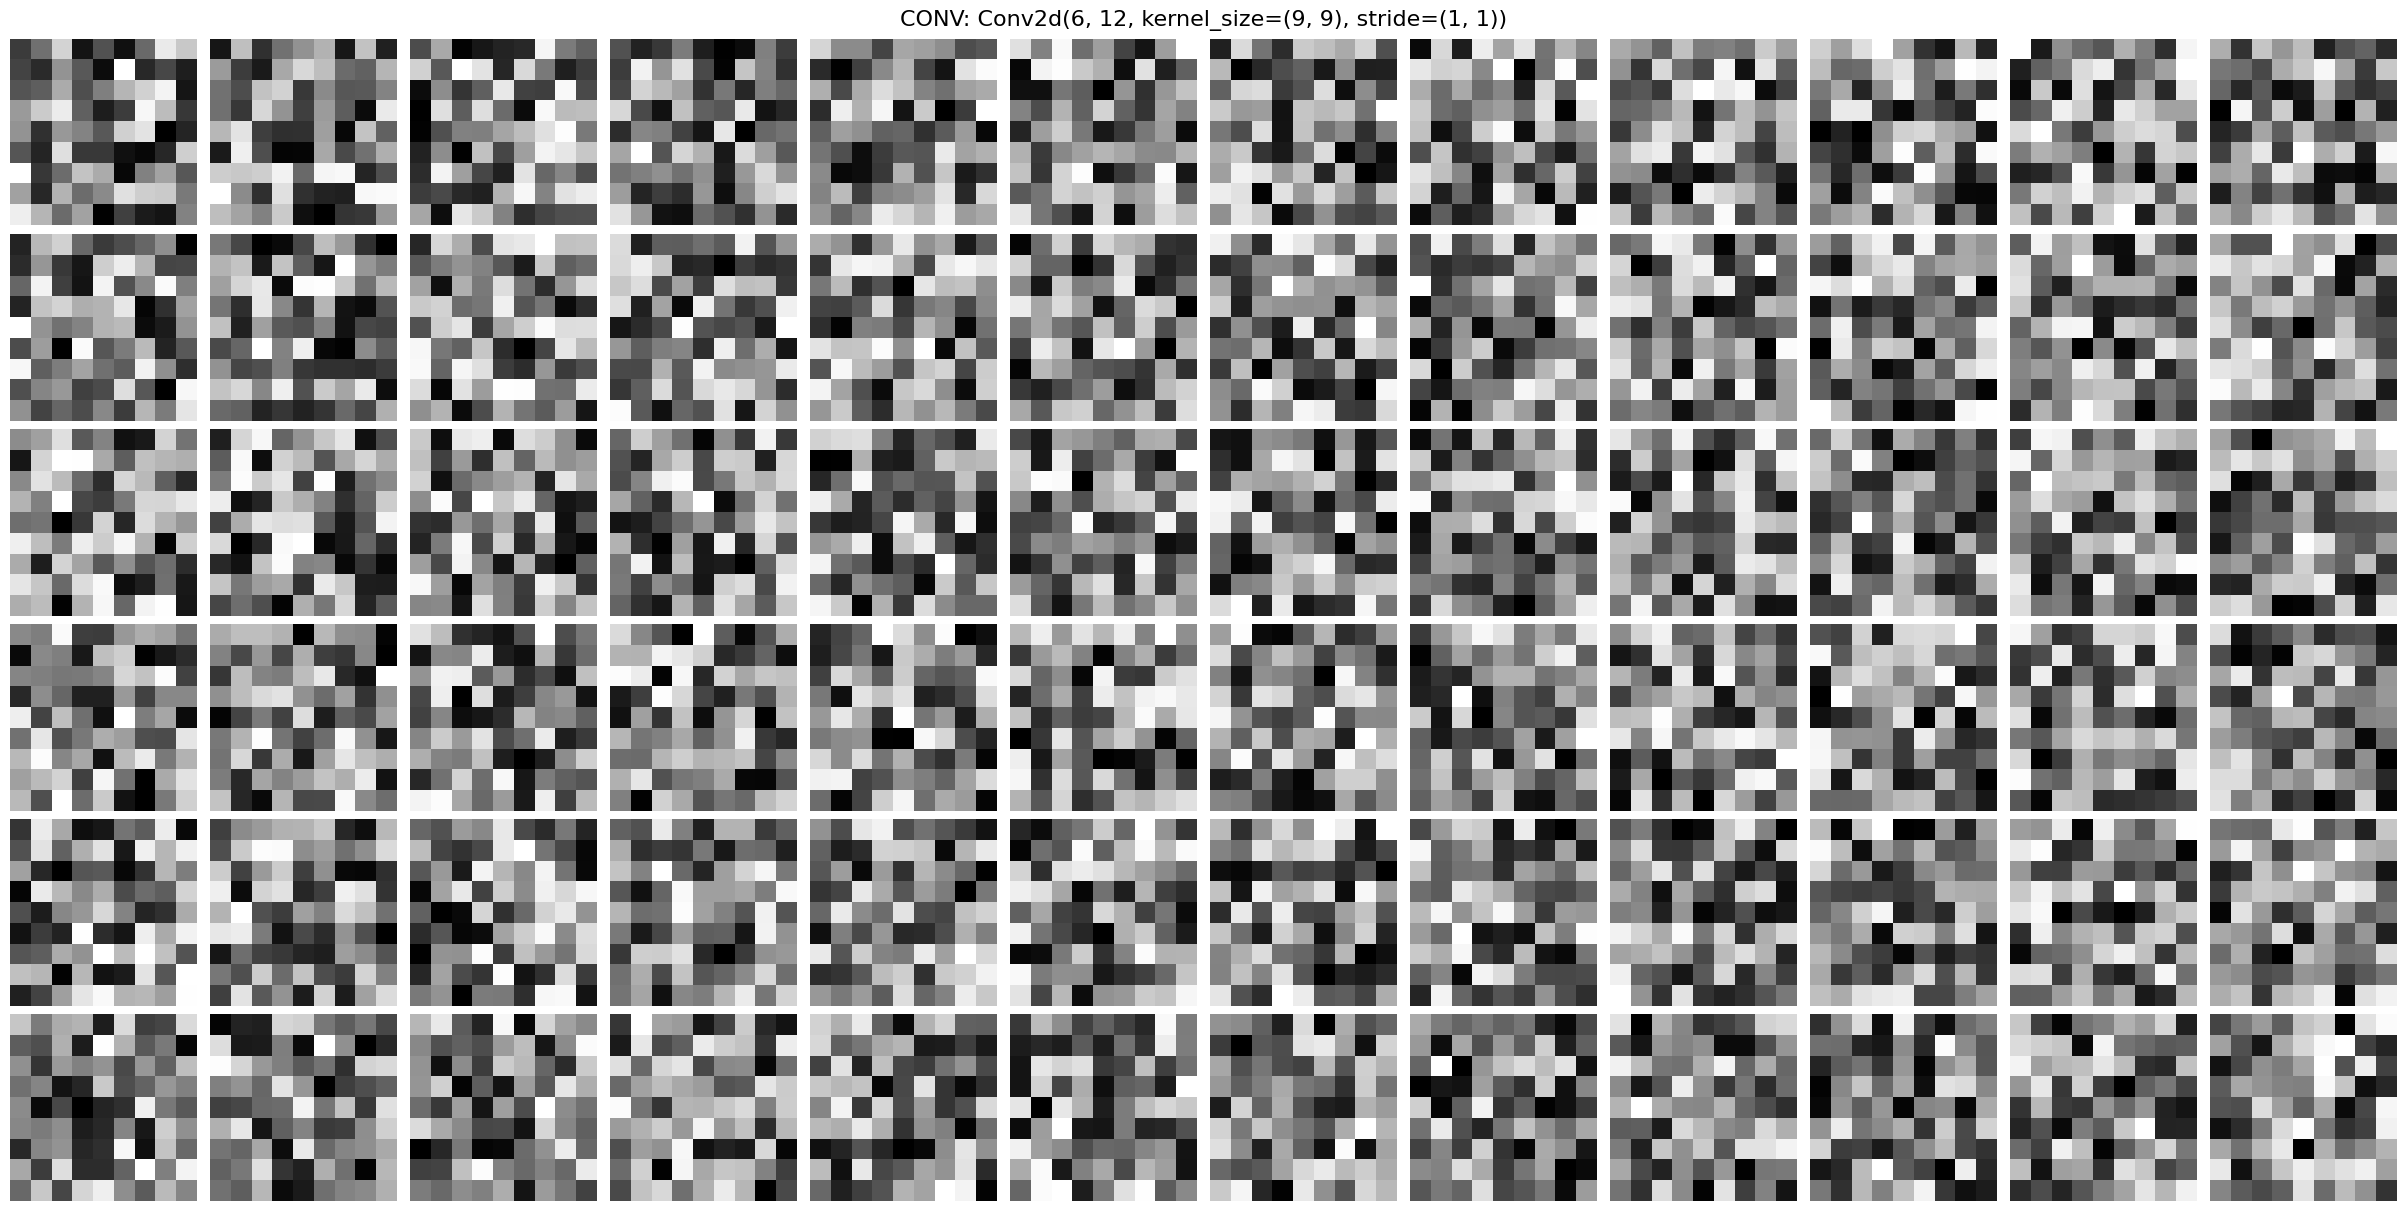

In [ ]:

def visualize_filters(convs):
    for conv in convs:
        in_ch, out_ch = conv.in_channels, conv.out_channels
        fig = plt.figure(figsize=(out_ch*2, in_ch*2), constrained_layout=True)
        fig.suptitle(f'CONV: {conv}', size=16)
        for i in range(in_ch):
            for j in range(out_ch):
                idx = (i*out_ch)+(j+1)
                ax = plt.subplot(in_ch, out_ch, idx)
                ax.axis('off')
                ax.imshow(conv.weight[j][i].detach(), cmap='gray')

                # Dim --> Out Ch x In Ch x K x K

convs = [nn.Conv2d(1, 6, 9), nn.Conv2d(6, 12, 9)]
visualize_filters(convs)

In [ ]:
def visualize_activations(convs, dataloader):
    for inputs, labels in dataloader:
        inputs = inputs.to(device)  # B x C x H x W
        img = inputs[:1]

        activations = [convs[0](img)]
        for i in range(1, len(convs)):
            activations.append(convs[i](activations[-1]))

        for conv, act in zip(convs, activations):
            out_ch = conv.out_channels
            fig = plt.figure(figsize=(out_ch*2, 2), constrained_layout=True)
            fig.suptitle(f'CONV: {conv}', size=16)
            for j in range(out_ch):
                ax = plt.subplot(1, out_ch, j+1)
                ax.axis('off')
                ax.imshow(act.detach().squeeze()[j].cpu(), cmap='gray')
                # Dim --> B x Out Ch x H' x W'
        return


visualize_activations(convs, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Grad-CAMs

<ipython-input-21-67b55e03e415>:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


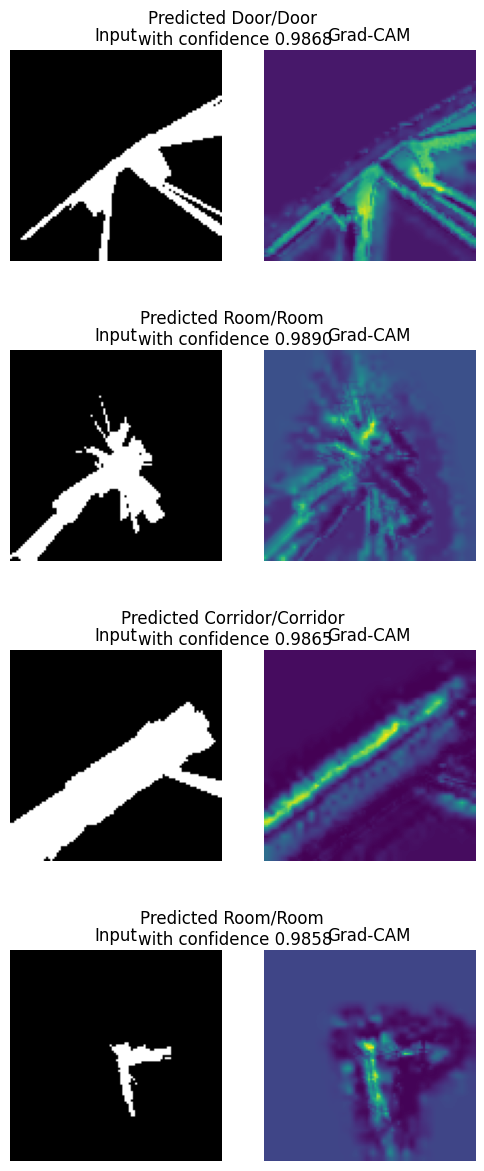

In [21]:
def visualize(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0

    cam = GradCAM(model=model, target_layers=model.features, use_cuda=False)

    fig = plt.figure(constrained_layout=True, figsize=(6,12))
    fig.tight_layout()
    subfigs = fig.subfigures(nrows=num_images, ncols=1)

    for inputs, labels in dataloader:
        inputs = inputs.to(device)                      # B x C x W x H
        labels = labels.to(device)

        outputs = model(inputs)                         # B x classes
        prob = nn.functional.softmax(outputs, dim=-1)
        prob, idx = prob.sort(1,True)                   # B x classes

        masks = cam(input_tensor=inputs[:num_images])

        for j in range(inputs.size()[0]):
            axs = subfigs[j].subplots(1, 2)
            subfigs[j].suptitle('Predicted {1}/{2} \nwith confidence {0:.4f}'.format(prob[j][0],
                class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
            axs[0].axis('off')
            axs[0].set_title('Input')
            axs[0].imshow(inputs[j].cpu().squeeze(), cmap='gray')
            axs[1].axis('off')
            axs[1].set_title('Grad-CAM')
            axs[1].imshow(masks[j])

            images_so_far += 1
            if images_so_far == num_images:
                model.train(mode=was_training)
                return

    model.train(mode=was_training)


visualize(net, dataloaders['test'] if mode=='train' else test_dataloader)

#Save the Trained Model

In [22]:
torch.save(net.state_dict(),root_dir+'<new_name_for_each_model>.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

# **Calculate by hand the difference in model parameters:**
Convolution: **bold text**
For the first Convolutional Layer,

       output size = (W − k + (2 × P ))/S+1
                   =(100-9+(2×0)/1+1
                   =92

Where,
H,W→ Height and Width of the Input= (100×100)

C→ Input Channel=1

O→ Output Channel=6

k→ Kernel Size=(9×9)

P→ Padding=0

S→ Stride=1

So, Output Shape = (92×92×6)


The Total Multiplications required to compute the Convolution is:

 6×9×9×1×(92×92 locations) = 4113504 or 4.1 million.


If there is bias, the number of parameters, First Conv2D, param1 is:

param1=(k × k × C + 1) ×N
             =(9×9×1+1)×6
             =492

Second Conv2D param2 is:


param2=(k × k × C + 1)× N
                       =(9×9×6+1)×12
                       =5844

where,
H, W → Height and Width of the Input=(100×100)

C → Number of Input Channels=1

N → Number of Kernels / Feature Maps=6

k → Kernel Size=(9×9)


Total trainable parameters = 492 + 5844 = 6336




**Depth-wise Separable Convolution:**


For depth-separable convolution the total multiplications required to compute the convolution is:

for depth wise:  9×9×1×(92×92 locations) = 685584

for point wise: 6×1×1×1×(92×92 locations) = 50784.

The Total Multiplications required to compute the Depth-Separable Convolution is:
 		(685584 + 50784 )= 736368 or 0.7 million.

A considerable decrease in the number of multiplications occurs. And for that reason, the runtime is faster.

params = DW-Conv params + PW-Conv params
where,,

DW-Conv params = (k × k ×1 + 1) × C
                              

PW-Conv params = (1 × 1 × C + 1) × N

First Conv2D, param1= (k × k × C) + (C × N) + (C + N)

            =(9× 9× 1)+(1× 6)+(1+6)

            =94
Second Conv2D, param2=(k × k × C) + (C × N) + (C + N)

            =(9×9×6)+(6×12)+(6+12)
            
            =576
Total trainable parameters = 94 + 576 = 670

The depth wise separable convolution requires less time to train a model because there are significantly less trainable parameters.


**Question1: Does accounting for class imbalance really have an effect on model performance? Try it Out!**
**Answer:** ImbalancedDatasetSampler class is used for handling the imbalanced dataset through modification  of the probability of sampling each class.In Dataloders, a bias in the model may occur if we do not employ any sampler. In this case, the model may perform well during training on the majority class but poorly on the minority class. The model is exposed to all classes more equally because of the ImbalancedDatasetSampler. This can greatly enhance the model's capacity to pick up information from minority classes, improving performance overall.

**Question2: Do you think increasing the receptive field would have a major effect on performance?**
**Try stacking convolutions or perhaps dilated convolutions to save up on learnable parameters ;)**

**Answer:**In stacking convolutions, multiple smaller kernel sizes are substituted for larger ones. This method adds more non-linearities and improves the receptive field at the same time as using fewer parameters. The efficiency is increased by using numerous smaller kernels, such as several 3x3 kernels, as opposed to a single bigger one (such as a 9x9 kernel as used in my code).

Conversely, by distributing zeros throughout the kernel elements, Dilated Convolutions expand the breadth of the kernel. This method increases the network's receptive field without changing the overall number of parameters.

Thus, by expanding the receptive area, the network may include local and global elements more efficiently, covering a wider range of contextual data. This results in a more thorough and in-depth comprehension of the information.


**Question3: identify the main sources of ambiguity for the model, if any. Try running a couple predictions and observing the cases where the model makes mistakes.**

**Answer:**Despite overfitting, the model does rather well on training, validation, and test datasets. Upon running several prediction cases,  a large number of the actual labels are incorrect. The model therefore memorizes the input and makes predictions using that.
